In [1]:
from skimage import io
import pickle
from photo import Photo
from collections import defaultdict
from pprint import pprint
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
%run ./posts_loader.py

community_id=-128623911
read posts: 4800
posts=4800


In [3]:
%run ./post_processor.py

photos: 4336


In [4]:
QUANTILE = 0.1
SECS = 7200
SEQUENCE = 50

In [5]:
def get_photos(file_name):
    return pickle.load(open(file_name, 'rb'))

In [6]:
with open('parameters.txt', 'r') as parameters:
    community_id = int(parameters.readline().split(' ')[0])
    count = int(parameters.readline().split(' ')[0])
    file_posts_info = parameters.readline().split(' ')[0]

print(community_id)
print(count)

-128623911
4800


In [7]:
photos = get_photos('{}-photos.txt'.format(community_id))[::-1]
photos = [photo for photo in photos if photo.likes]
print(len(photos))

4298


In [8]:
def draw_avg_graph(photos, p=SEQUENCE, w=18.5, h=12.5, title=None):
    X = [photo.day for photo in photos]
    likes = [photo.likes for photo in photos]
    avg_likes = [sum(likes[t:t+p])/(p+0.0) for t in range(len(likes) - p)]
    plt.plot(X[:-p], avg_likes)
    plt.xlabel('days')
    plt.ylabel('likes')
    fig = plt.gcf()
    fig.set_size_inches(w, h)
    if title is not None:
        plt.title(title)
    plt.show()

def soft_avg(likes):
    left_quantile = int(QUANTILE * len(likes))
    right_quantile = int((1 - QUANTILE) * len(likes))
    sorted_likes = sorted(likes)
    sorted_likes = sorted_likes[left_quantile:right_quantile]
    return sum(sorted_likes)/(len(sorted_likes) + 0.0)

def draw_soft_avg_graph(photos, p=SEQUENCE, w=18.5, h=12.5, title=None):
    X = [photo.day for photo in photos]
    likes = [photo.likes for photo in photos]
    avg_likes = [soft_avg(likes[t:t+p]) for t in range(len(likes) - p)]
    plt.plot(X[:-p], avg_likes)
    plt.xlabel('days')
    plt.ylabel('likes')
    fig = plt.gcf()
    fig.set_size_inches(w, h)
    if title is not None:
        plt.title(title)
    plt.show()
    
    

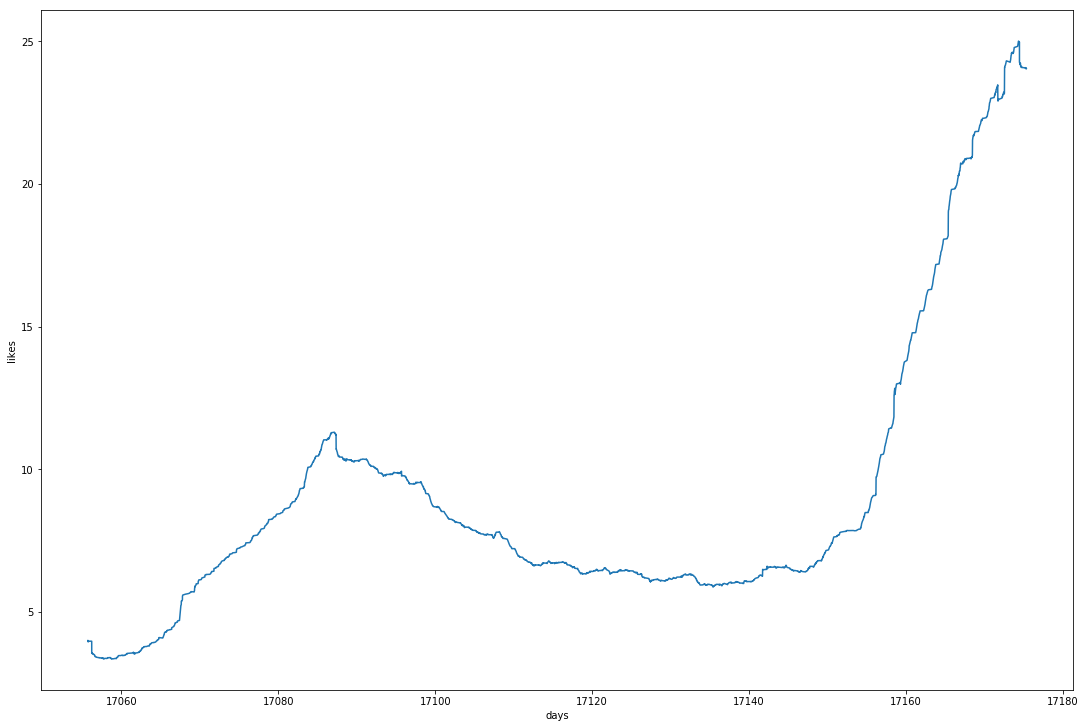

In [9]:
draw_avg_graph(photos, p=500)

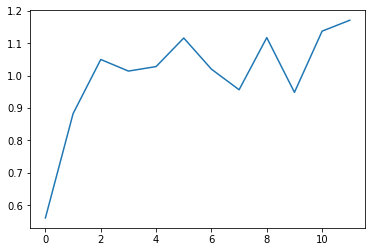

In [10]:
photos_div_t = defaultdict(list)
for photo in photos:
    photos_div_t[photo.second // SECS].append(photo)
lens = list(map(len, photos_div_t.values()))
# pprint (lens)
avgs = [sum([photo.likes for photo in sub_photos]) / len(sub_photos) for sub_photos in photos_div_t.values()]
# pprint(avgs)
norm_avgs = [len(avgs) * avg / sum(avgs) for avg in avgs]
# pprint(norm_avgs)
plt.plot(list(range(86400 // SECS)), norm_avgs)
plt.show()

Нормированная конверсия выставления лайков. Видно, что с 0 по 4 часа утра лайкают в два раза меньше среднего, на максимум график выходит к позднему вечеру.

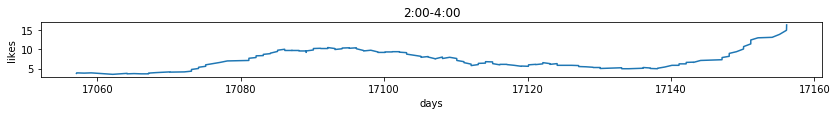

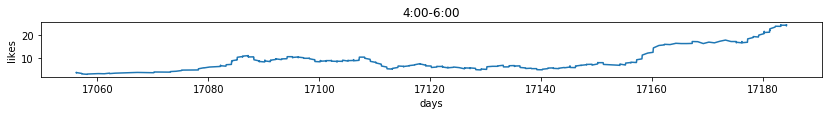

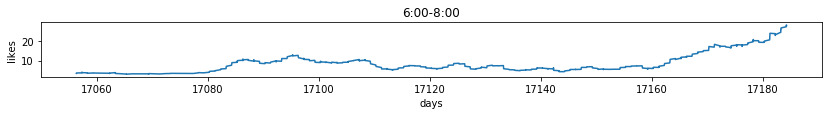

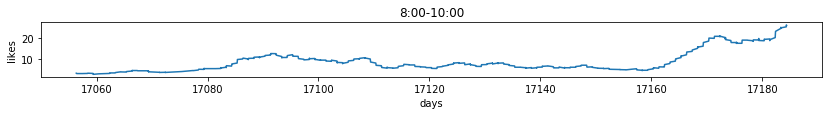

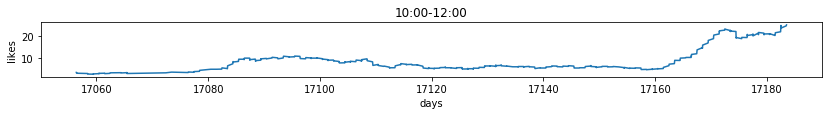

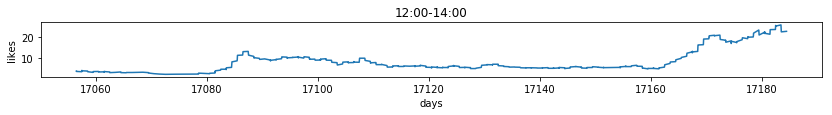

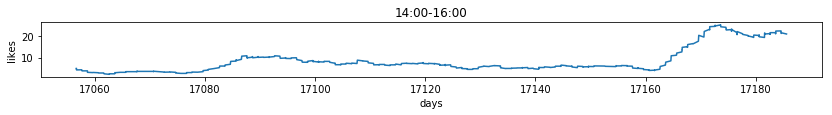

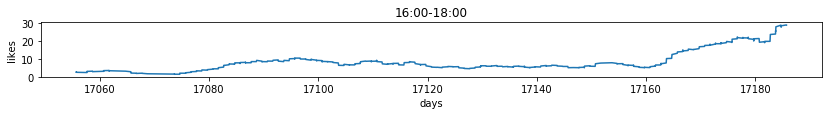

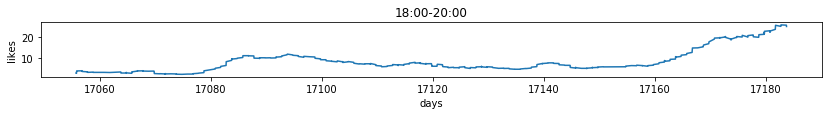

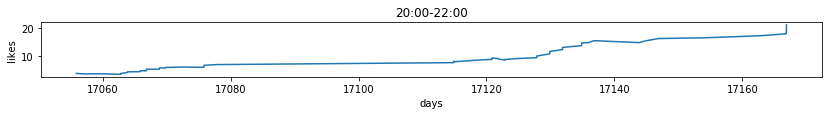

In [11]:
for hour in photos_div_t.keys():
    if len(photos_div_t[hour]) > 40:
        # draw_avg_graph(photos_div_t[hour], p=20)
        draw_soft_avg_graph(photos_div_t[hour],
                            p=20,
                            w=14,
                            h=1,
                            title='{}:00-{}:00'.format(2*hour, 2*hour+2))

Количество лайков в разрезе по времени суток

In [12]:
def get_photo_rates(photos, expectations):
    exp_rates = [photo.likes / expectations[photo.second // SECS] for photo in photos] 
    soft_avgs = [soft_avg(exp_rates[t:t+SEQUENCE]) for t in range(len(exp_rates)-SEQUENCE)]
    return [[photo, math.log(exp_rate / avg + 1)] 
            for photo, avg, exp_rate in
            zip(photos, soft_avgs, exp_rates)]

In [13]:
photo_rates = get_photo_rates(photos, norm_avgs)
photo_rates.sort(key=lambda p_r: p_r[1], reverse=True)
for p_r in photo_rates[0:100]:
    img=io.imread(p_r[0].link)
    # w = img.shape[0]
    # h = img.shape[1]
    # fig = plt.gcf()
    # fig.set_size_inches( h/200, w/200)
    # plt.axis('off')
    # plt.rc('savefig', dpi=150)
    # plt.title(str(p_r[1]))
    # plt.imshow(img)
    # plt.show()
    io.imsave('very_best_of_obkontent/{}.png'.format(p_r[1]), img)
    # plt.show()

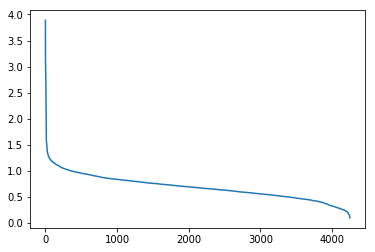

In [14]:
X = list(range(len(photo_rates)))
Y = [p_r[1] for p_r in photo_rates]
plt.plot(X, Y)

Логарифмическая шкала убывания конверсии